# 0 Initialise

### Import Packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mimic_constants import *
from os import makedirs
from xgboost import XGBClassifier
from CardiomegalyBiomarkers.Cardiomegaly_Classification.src.xgboost_functions import SplitData, train_test_xgboost

/home/ays124/mimic/venv/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Paths

In [2]:
# Path for model location and error graphs
model_folder = 'CardiomegalyBiomarkers/Cardiomegaly_Classification/models/xgboost/'
makedirs(model_folder, exist_ok=True)

### Model Parameters

In [3]:
# Data parameters
TrainTestFractions = [0.9, 0.1] # Spits of data for training/validation and testing sets
FoldFractions = [0.2, 0.2, 0.2, 0.2, 0.2] # Spits of data for folds

# XGBoost parameters
eval_metric = 'logloss'
scale_pos_weight = 0.3/0.7
colsample_bytree = 0.75
gamma = 0
lr = 0.1
subsample = 0.75

max_depth_shallow = 3
max_depth_deep = 8

early_stopping = 15

In [4]:
# Feature selection for model
base = ['subject_id', 'hadm_id', 'stay_id', 'path'] # base features

vital = ['HR_mean', 'ABPs_mean', 'ABPd_mean', 'ABPm_mean', 'NBPs_mean', 'NBPd_mean',  # vital sign features (V)
         'NBPm_mean', 'RR_mean', 'PO2_mean', 'SaO2_mean', 'PCO2_mean', 'PH_mean', 'SpO2_mean', 
         'Cholesterol_mean', 'Sodium_mean', 'Temp(F)_mean', 'FiO2_mean', 'Albumin_mean', 
         'PlateletCount_mean', 'HR_max', 'ABPs_max', 'ABPd_max', 'ABPm_max', 'NBPs_max', 
         'NBPd_max', 'NBPm_max', 'RR_max', 'PCO2_max', 'Sodium_max', 'FiO2_max', 'HR_min', 
         'ABPs_min', 'ABPd_min', 'ABPm_min', 'NBPs_min', 'NBPd_min', 'NBPm_min', 'RR_min', 
         'PCO2_min', 'SpO2_min', 'Sodium_min']


lab = ['Hemoglobin_mean', 'Lactate_mean', 'Tidal_Volume_mean', 'ALT_mean', 'Alkaline_Phosphatase_mean', # laboratory features (L)
       'Bilirubin', 'Calcium_Total_mean', 'Chloride_mean', 'Creatinine_mean', 'Glucose_mean', 
       'Magnesium_mean', 'Phosphate_mean', 'Potassium_mean', 'Troponin-T_mean', 'Urea_Nitrogren_mean', 
       'Fibrinogen', 'Hematocrit_mean', 'PTT_mean', 'WBC_mean', 'Hemoglobin_max', 'Potassium_max', 
       'Troponin-T_max', 'WBC_max', 'Hemoglobin_min', 'Potassium_min', 'WBC_min']

meta_cont = ['los', 'anchor_age']                # continuous metadata features (M)
meta_cat = ['gender']                            # categorical metadata features (M)
meta_cat_encoded = ['gender_F', 'gender_M']      # encoded catgeorical metadata features

bmrks = ['CTR', 'CPAR']     # biomarker features (BMRK)

# Select modality combinations tested (list of lists)
modalities_combinations = [[vital + lab + meta_cont + meta_cat_encoded, 'M_L_V'],
                           [bmrks, 'BMRK'], 
                           [vital + lab + meta_cont + meta_cat_encoded + bmrks, 'M_L_V_BMRK']]

# 1 Data Prepocessing

In [5]:
# Read 
data = get_master_df(idp=True)

# Change name of column to indicate class deoaration
data.rename(columns={'Cardiomegaly':'class'}, inplace=True)

[TrainVal_df, Test_df] = SplitData(data, TrainTestFractions)

# Split trainval into folds
[Fold1_df, Fold2_df, Fold3_df, Fold4_df, Fold5_df] = SplitData(TrainVal_df, FoldFractions)

In [6]:
# Preprocess folds for xgboost use by selecting features and encoding categorical features
Fold1_df = pd.concat([Fold1_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold1_df[meta_cat]), Fold1_df['class']], axis=1)
Fold2_df = pd.concat([Fold2_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold2_df[meta_cat]), Fold2_df['class']], axis=1)
Fold3_df = pd.concat([Fold3_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold3_df[meta_cat]), Fold3_df['class']], axis=1)
Fold4_df = pd.concat([Fold4_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold4_df[meta_cat]), Fold4_df['class']], axis=1)
Fold5_df = pd.concat([Fold5_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Fold5_df[meta_cat]), Fold5_df['class']], axis=1)

# Preprocess test set for xgboost use by selecting features and encoding categorical features
Test_df = pd.concat([Test_df[base + vital + lab + meta_cont + bmrks], pd.get_dummies(Test_df[meta_cat]), Test_df['class']], axis=1)

# 2 Model Training and Testing

[0]	validation_0-logloss:0.51331	validation_1-logloss:0.52413
[0]	validation_0-logloss:0.51331	validation_1-logloss:0.52413
[1]	validation_0-logloss:0.49515	validation_1-logloss:0.51366
[1]	validation_0-logloss:0.49515	validation_1-logloss:0.51366
[2]	validation_0-logloss:0.47954	validation_1-logloss:0.51129
[2]	validation_0-logloss:0.47954	validation_1-logloss:0.51129
[3]	validation_0-logloss:0.46209	validation_1-logloss:0.50067
[3]	validation_0-logloss:0.46209	validation_1-logloss:0.50067
[4]	validation_0-logloss:0.44627	validation_1-logloss:0.49240
[4]	validation_0-logloss:0.44627	validation_1-logloss:0.49240
[5]	validation_0-logloss:0.43112	validation_1-logloss:0.48661
[5]	validation_0-logloss:0.43112	validation_1-logloss:0.48661
[6]	validation_0-logloss:0.42051	validation_1-logloss:0.48783
[6]	validation_0-logloss:0.42051	validation_1-logloss:0.48783
[7]	validation_0-logloss:0.40825	validation_1-logloss:0.48716
[7]	validation_0-logloss:0.40825	validation_1-logloss:0.48716
[8]	vali

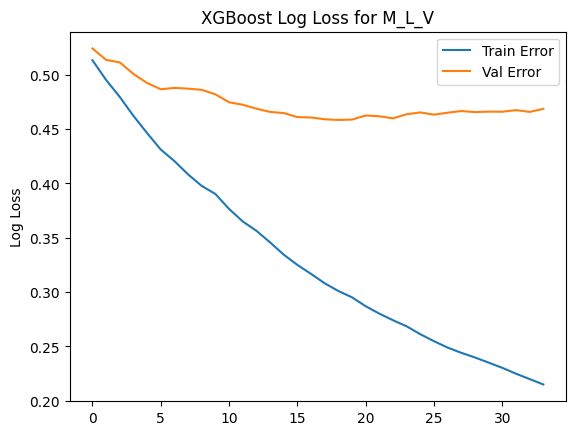

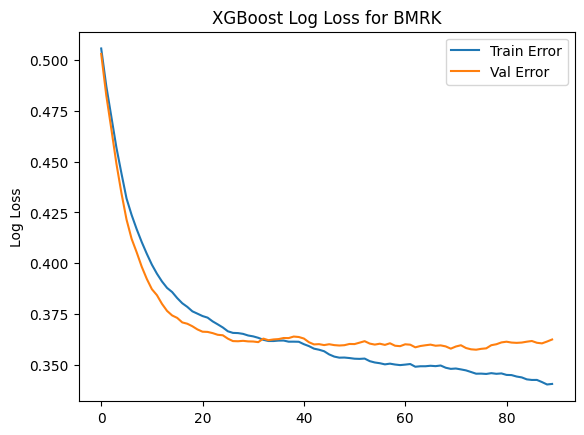

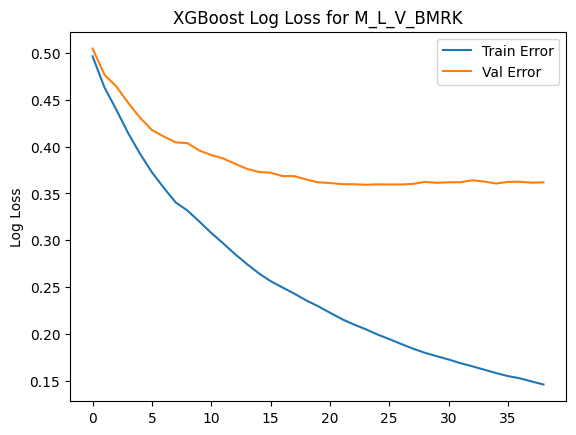

In [23]:
# define dict of model parameters
model_params = {'eval_metric' : eval_metric,
                'scale_pos_weight' : scale_pos_weight,
                'colsample_bytree' : colsample_bytree,
                'gamma' : gamma,
                'lr' : lr,
                'subsample' : subsample, 
                'max_depth_shallow' : max_depth_shallow,
                'max_depth_deep' : max_depth_deep,
                'early_stopping' : early_stopping}


# getmodels, train and test, return pandas of results using k-fold cross validation
# -> if lossFigure and saveModels are True, then figures of training and validation losses and models are saved in ./MOdel/xgboost/
results_fold1 = train_test_xgboost([Fold2_df, Fold3_df, Fold4_df, Fold5_df], Fold1_df, 1, Test_df, modalities_combinations, model_params, model_folder, lossFigure = True, exportModels = True)
results_fold2 = train_test_xgboost([Fold1_df, Fold3_df, Fold4_df, Fold5_df], Fold2_df, 2, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold3 = train_test_xgboost([Fold2_df, Fold1_df, Fold4_df, Fold5_df], Fold3_df, 3, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold4 = train_test_xgboost([Fold2_df, Fold3_df, Fold1_df, Fold5_df], Fold4_df, 4, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)
results_fold5 = train_test_xgboost([Fold2_df, Fold3_df, Fold4_df, Fold1_df], Fold5_df, 5, Test_df, modalities_combinations, model_params, model_folder, lossFigure = False, exportModels = True)


In [ ]:
# These lines are inlcuded to show how to load an exported xgboost model for predictions on new data
'''
model_load = XGBClassifier()
model_load.load_model(model_folder + 'BMRK_fold1_model.json')
'''

# 3 Results Analysis

In [24]:
# display results per fold
print(f'#######   VAL FOLD: fold 1   ########')
display(results_fold1)

print(f'#######   VAL FOLD: fold 2   ########')
display(results_fold2)

print(f'#######   VAL FOLD: fold 3   ########')
display(results_fold3)

print(f'#######   VAL FOLD: fold 4   ########')
display(results_fold4)

print(f'#######   VAL FOLD: fold 5   ########')
display(results_fold5)

#######   VAL FOLD: fold 1   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.791045,0.517241,0.066667,"[[105, 0], [28, 1]]"
BMRK,0.828358,0.640887,0.439024,"[[102, 3], [20, 9]]"
M_L_V_BMRK,0.791045,0.604598,0.363636,"[[98, 7], [21, 8]]"


#######   VAL FOLD: fold 2   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.776119,0.507718,0.062500,"[[103, 2], [28, 1]]"
BMRK,0.798507,0.584401,0.307692,"[[101, 4], [23, 6]]"
M_L_V_BMRK,0.813433,0.668801,0.489796,"[[97, 8], [17, 12]]"


#######   VAL FOLD: fold 3   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.783582,0.500000,0.000000,"[[105, 0], [29, 0]]"
BMRK,0.828358,0.678325,0.510638,"[[99, 6], [17, 12]]"
M_L_V_BMRK,0.791045,0.617077,0.391304,"[[97, 8], [20, 9]]"


#######   VAL FOLD: fold 4   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.776119,0.507718,0.062500,"[[103, 2], [28, 1]]"
BMRK,0.820896,0.661084,0.478261,"[[99, 6], [18, 11]]"
M_L_V_BMRK,0.791045,0.617077,0.391304,"[[97, 8], [20, 9]]"


#######   VAL FOLD: fold 5   ########


,Accuracy,ROC AUC,F1 score,Confusion Matrix
Modalities,,,,
M_L_V,0.776119,0.495238,0.000000,"[[104, 1], [29, 0]]"
BMRK,0.776119,0.545156,0.210526,"[[100, 5], [25, 4]]"
M_L_V_BMRK,0.798507,0.584401,0.307692,"[[101, 4], [23, 6]]"


In [25]:
# Average performance scores over 5 folds and split per feature used
results = pd.concat([results_fold1, results_fold2, results_fold3, results_fold4, results_fold5])

modalities = list(set(results.index.tolist()))

for modality in modalities:
    results_summary = pd.concat([results['Accuracy'].loc[modality].describe(), results['ROC AUC'].loc[modality].describe(), results['F1 score'].loc[modality].describe()], axis=1)
    results_summary.columns = ['Accuracy', 'ROC AUC', 'F1 score']
    print(f'#######   AVG OVER 5 FOLDS: {modality}    ########')
    display(results_summary.iloc[1:3])

#######   AVG OVER 5 FOLDS: BMRK    ########


,Accuracy,ROC AUC,F1 score
mean,0.810448,0.621970,0.389228
std,0.022758,0.055623,0.126223


#######   AVG OVER 5 FOLDS: M_L_V_BMRK    ########


,Accuracy,ROC AUC,F1 score
mean,0.797015,0.618391,0.388747
std,0.009730,0.031186,0.066001


#######   AVG OVER 5 FOLDS: M_L_V    ########


,Accuracy,ROC AUC,F1 score
mean,0.780597,0.505583,0.038333
std,0.006675,0.008415,0.035035


# 4 Feature Importance

In [26]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'M_L_V_fold1_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[0][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(10)

,Feature,Importance
21,ABPd_max,0.041550
55,Urea_Nitrogren_mean,0.040018
10,PCO2_mean,0.028118
39,SpO2_min,0.024994
33,ABPm_min,0.024926
68,anchor_age,0.024798
61,Potassium_max,0.021957
51,Magnesium_mean,0.020652
9,SaO2_mean,0.020078
16,FiO2_mean,0.019488


In [27]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'BMRK_fold1_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[1][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(10)

,Feature,Importance
0,CTR,0.567708
1,CPAR,0.432292


In [28]:
model_load = XGBClassifier()
model_load.load_model(model_folder + 'M_L_V_BMRK_fold2_model.json')
# Feature importances from the trained XGBoost model
feature_importances = model_load.feature_importances_
important_features = pd.DataFrame({
    'Feature': modalities_combinations[2][0],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

important_features.head(12)

,Feature,Importance
71,CTR,0.099010
72,CPAR,0.058440
3,ABPm_mean,0.041702
8,PO2_mean,0.033091
26,RR_max,0.031975
55,Urea_Nitrogren_mean,0.023471
21,ABPd_max,0.022406
64,Hemoglobin_min,0.022000
15,Temp(F)_mean,0.018330
51,Magnesium_mean,0.017351
